# Comparing Cython, Numpy and Numba for a PFR Distributed Model

## The model

Consider a simple PFR reactor as follows:

![](pfr_scheme.png)

The concentration inside the reactor can be described in the position $z$ and time $t$ by the partial differential equation:

$$\frac{\partial C(t,z)}{\partial t} + v_z \frac{\partial C(t,z)}{\partial z} - D \frac{\partial^2 C(t,z)}{\partial t^2} - r(t,z) = 0$$

$$C(0,z) = C_{ini}(z)$$

$$C(t,0) - \frac{D}{v_z}\frac{d C(t,z)}{dz}\Big\vert_{z=0} = C_f(t)$$

$$\frac{D}{v_z}\frac{d C(t,z)}{dz}\Big\vert_{z=L} = 0$$

An approach to solve this PDE is discretizing the $z$ domain and approximating the derivatives using finite differences. Doing so we obtain the final set of equation as an ordinary differential equation set in the form $\frac{d \mathbf{C}}{d t} = f(\mathbf{C})$.

$$\frac{dC_1(t)}{dt} = \frac{D}{h^2}(C_2 - 2C_1 + C_0) - \frac{v_z}{2h}(C_2-C_0) + r_1$$

$$\frac{dC_i(t)}{dt} = \frac{D}{h^2}(C_{i+1} - 2C_{i} + C_{i-1}) - \frac{v_z}{2h}(C_{i+1}-C_{i-1}) + r_{i} \text{ for } i=2,\ldots, N-1 $$ 

$$\frac{dC_N(t)}{dt} = \frac{D}{h^2}(C_{N+1} - 2C_{N} + C_{N-1}) - \frac{v_z}{2h}(C_{N+1}-C_{N-1}) + r_{N}$$

with:

$$C_0 = \left( 1 + \frac{D}{v_z h}\right)^{-1}\left(\frac{D}{v_z h} C_1 + C_f \right)$$

$$C_{N+1}=C_N$$

In the next, this problem is solved using python, cython, numpy and numba. Moreover, a performance comparison is provided for various values of the number of discretization points.

In [1]:
import numpy as np
#import dasslcy
from scipy.integrate import ode
from functools import partial
import perfplot
import numba

In [2]:
NPTS = 100
# dyn_solver = partial(dasslcy.solve, share_res=1)
# integrate.ode
%load_ext Cython

In [22]:
def integrate_rk3(t0, ti, y, fun, f_args):
    h = ti - t0
    if f_args is not None:
        k1 = h * fun(t0, y, f_args)
        k2 = h * fun(t0 + h/2, y + k1/2, f_args)
        k3 = h * fun(t0 + h, y - k1 + 2*k2, f_args)
        ynew = y + 1/6*(k1 + 4.*k2 + k3)
    else:
        k1 = h * fun(t0, y)
        k2 = h * fun(t0 + h/2, y + k1/2)
        k3 = h * fun(t0 + h, y - k1 + 2*k2)
        ynew = y + 1/6*(k1 + 4.*k2 + k)        
    return ynew

def multiples_rk(t0, ti, y, fun, f_args, Nintervals = 100):
    tspan = np.linspace(t0, ti, Nintervals + 1)
    for t in tspan:
        ynew = integrate_rk3(t0, ti, y, fun, f_args)

In [33]:
# def dyn_solver(fun, tnext, y0, par = None, rtol=1e-5, atol=1e-5):
#     r = ode(fun).set_integrator('vode', method='bdf',nsteps=15000, rtol=rtol, atol=atol)
#     r.set_initial_value(y0, 0.0)
#     r.set_f_params(par)
#     r.integrate(tnext)
#     return r.t, r.y

def dyn_solver(fun, tnext, y0, par = None):
    ynew = multiples_rk(0.0, tnext, y0, fun, par, Nintervals=5000)
    return ynew

## Class for the model data

In [46]:
class pfr():
    def __init__(self, N = 20):
        self.D = 1.0
        self.vz = 1.0
        self.k = 1.0
        self.Cf = 1.0
        self.z0 = 0.0
        self.zf = 1.0
        self.N = N
        self.h = self.get_h()

    def get_h(self):
        return (self.zf - self.z0) / self.N
    
# def solver_setup_base(N):
#     par = pfr(N)
#     t0 = np.array([0.1])
#     y0 = np.zeros(par.N)
#     #yp0 = None
#     atol = 1e-5
#     rtol = 1e-5
#     return [t0, y0, par, rtol, atol]

def solver_setup_base(N):
    par = pfr(N)
    t0 = np.array([0.1])
    y0 = np.zeros(par.N)
    return [t0, y0, par]

## Pure Python

Setting dynamic model and solving

In [47]:
def model_pfr(t, y, par):
    rhs = np.empty_like(y)
    N = par.N
    D, vz, k, Cf, h = par.D, par.vz, par.k, par.Cf, par.h
    #dCi = yp
    Ci = y
    aux1 = D / (vz * h)
    C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
    CNp1 = Ci[N - 1]
    aux2 = D / h**2
    aux3 = vz / (2 * h)
    rhs[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
        aux3 * (Ci[1] - C0) + k * Ci[0]
    for i in np.arange(1, N - 1):
        tt1 = aux2 * (Ci[i + 1] - 2.0 * Ci[i] + Ci[i - 1])
        tt2 = -aux3 * (Ci[i + 1] - Ci[i - 1]) + k * Ci[i]
        rhs[i] = tt1 + tt2
    rhs[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
        aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1]
    return rhs

In [36]:
#model_pfr(0.0, base_args[1], base_args[2])
# model_pfr(*base_args)
#integrate_rk3(0.0, 0.1, base_args[1], model_pfr, base_args[2])

In [37]:
base_args = solver_setup_base(NPTS)
o = %timeit -r 2 -n 1 -o dyn_solver(model_pfr, *base_args) 

4.13 s ± 52.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## Numpy broadcasting

In [38]:
def model_pfr_np(t, y, par):
    rhs = np.empty_like(y)
    N = par.N
    D, vz, k, Cf, h = par.D, par.vz, par.k, par.Cf, par.h
    # dCi = yp
    Ci = y
    aux1 = D / (vz * h)
    C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
    CNp1 = Ci[N - 1]
    aux2 = D / h**2
    aux3 = vz / (2 * h)
    rhs[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
        aux3 * (Ci[1] - C0) + k * Ci[0]
    tt1 = aux2 * (Ci[2:] - 2.0 * Ci[1:-1] + Ci[0:-2])
    tt2 = -aux3 * (Ci[2:] - Ci[0:-2]) + k * Ci[1:-1]
    rhs[1:-1] = tt1 + tt2

    rhs[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
        aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1]
    return rhs

In [39]:
o = %timeit -r 10 -n 1 -o dyn_solver(model_pfr_np, *base_args)

439 ms ± 24.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Cython Naive implementation

In [40]:
%%cython
import numpy as np
cimport numpy as np
def model_pfr_cy(t, y, par):
    rhs = np.empty_like(y)
    N = par.N
    D, vz, k, Cf, h = par.D, par.vz, par.k, par.Cf, par.h
    # dCi = yp
    Ci = y
    aux1 = D / (vz * h)
    C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
    CNp1 = Ci[N - 1]
    aux2 = D / h**2
    aux3 = vz / (2 * h)
    rhs[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
        aux3 * (Ci[1] - C0) + k * Ci[0]
    for i in np.arange(1, N - 1):
        tt1 = aux2 * (Ci[i + 1] - 2.0 * Ci[i] + Ci[i - 1])
        tt2 = -aux3 * (Ci[i + 1] - Ci[i - 1]) + k * Ci[i]
        rhs[i] = tt1 + tt2
    rhs[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
        aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1]
    return rhs

In [41]:
o = %timeit -r 2 -n 1 -o dyn_solver(model_pfr_cy, *base_args)

3.38 s ± 23.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


## Cython Typed Implementation

In [48]:
%%cython
import numpy as np
cimport numpy as np
cimport cython 

#cython: boundscheck=False
#cython: wraparound=False

cdef class Pfr_Cython:
    cdef:
        double D, vz, k, Cf, z0, zf, h
        int N
    def __init__(self, N = 20):
        self.N = N
        self.D = 1.0
        self.vz = 1.0
        self.k = 1.0
        self.Cf = 1.0
        self.z0 = 0.0
        self.zf = 1.0
        self.h = self.get_h()
    cdef get_h(self):
        return (self.zf - self.z0) / self.N
    
    @cython.boundscheck(False)  # Deactivate bounds checking
    @cython.wraparound(False)   # Deactivate negative indexing.
    @cython.nonecheck(False)
    @cython.cdivision(True)    
    cdef cythonized_base_model_calculations(self, double t, np.float64_t[:] y, np.float64_t[:] rhs,
                int N, double D, double vz, double k, double Cf, double h):
        cdef:
            int i
            double tt1, tt2
        # cdef np.float64_t[:] dCi = yp
        cdef np.float64_t[:] Ci = y
        cdef double aux1 = D / (vz * h)
        cdef double C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
        cdef double CNp1 = Ci[N - 1]
        cdef double aux2 = D / h**2
        cdef double aux3 = vz / (2 * h)
        rhs[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
            aux3 * (Ci[1] - C0) + k * Ci[0]
        for i in range(1, N - 1):
            tt1 = aux2 * (Ci[i + 1] - 2.0 * Ci[i] + Ci[i - 1])
            tt2 = -aux3 * (Ci[i + 1] - Ci[i - 1]) + k * Ci[i]
            rhs[i] = tt1 + tt2
        rhs[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
            aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1]
        pass
    
    @cython.boundscheck(False)  # Deactivate bounds checking
    @cython.wraparound(False)   # Deactivate negative indexing. 
    @cython.nonecheck(False)
    @cython.cdivision(True)
    cpdef cython_model(self, double t, np.float64_t[:] y, np.float64_t[:] rhs):
        self.cythonized_base_model_calculations(t, y, rhs, self.N, 
                                                self.D, self.vz, 
                                                self.k, self.Cf, self.h)
        return rhs

In [49]:
#initialize_cy_pfr_model(NPTS)
pr_Cy = Pfr_Cython(NPTS)
cy_args = solver_setup_base(NPTS)
# return [t0, y0, par, rtol, atol]
rhs_for_cy = np.zeros_like(cy_args[1])
cy_args[2] = rhs_for_cy

In [61]:
o = %timeit -r 10 -n 1 -o dyn_solver(pr_Cy.cython_model, *cy_args)

224 ms ± 10.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Numba

- Create a function closure to define numba scoped variables

In [57]:
spec = [
    ('N', numba.int32),
    ('D', numba.float64),
    ('vz', numba.float64),
    ('k', numba.float64),
    ('Cf', numba.float64),
    ('z0', numba.float64),
    ('zf', numba.float64),
    ('h', numba.float64),
]
Numba_PFR = numba.jitclass(spec)(pfr)
jitted_pfr_model = numba.jit(model_pfr, nopython=True)
# def wrapper_numba_fun(t, y, par): 
#     """integrate.ode cannot operate directly in the jitted function!"""
#     return jitted_pfr_model(t, y, par)
numba_pfr = Numba_PFR(NPTS)
numba_args = solver_setup_base(NPTS)
numba_args[2] = numba_pfr

In [64]:
o = %timeit -r 10 -n 1 -o dyn_solver(jitted_pfr_model, *numba_args)

179 ms ± 15.2 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Performance for discretization point 

In [71]:
def setups_all(N):
    # Numpy
    base_args = solver_setup_base(N)
    
    # Cython
    pr_Cy = Pfr_Cython(N)
    cy_args = solver_setup_base(N)
    rhs_for_cy = np.zeros_like(cy_args[1])
    cy_args[2] = rhs_for_cy    
    
    # Numba
    numba_pfr = Numba_PFR(N)
    numba_args = solver_setup_base(N)
    numba_args[2] = numba_pfr   
    return base_args, (pr_Cy, cy_args), numba_args

def run_py(opts_setup):
#     base_args = solver_setup_base(N)
    dyn_solver(model_pfr, *opts_setup[0])
    return 0

# def setup_np(N):
#     return solver_setup_base(N)

def run_np(opts_setup):
    dyn_solver(model_pfr_np, *opts_setup[0])
    return 0

def run_cy_naive(opts_setup):
    #base_args = solver_setup_base(N)
    dyn_solver(model_pfr_cy, *opts_setup[0])
    return 0

def run_cy_typed(opts_setup):
    #dyn_solver(pr_Cy.cython_model, *cy_args)
    dyn_solver(opts_setup[1][0].cython_model, *opts_setup[1][1])
    return 0

def run_numba(opts_setup):
    numba_args = opts_setup[2]
    # solve_ivp(numba_model_fun, [0, numba_args[0]], numba_args[1], method='BDF')
    dyn_solver(jitted_pfr_model, *numba_args)
    return 0

kernels = [run_np, run_cy_typed, run_numba]

100%|██████████| 14/14 [00:57<00:00,  4.12s/it]


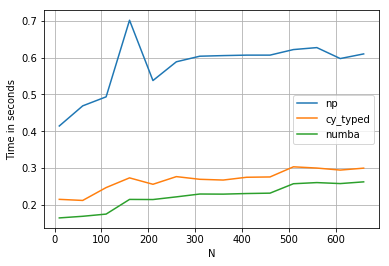

In [73]:
perfplot.show(
    setup= setups_all,
    kernels= kernels,
    labels=['np', 'cy_typed', 'numba'],
    n_range=[10*k for k in range(1, 60+10, 5)], #n_range=[2**k for k in range(1, 100 + 10, 10)],
    xlabel='N'
    )